# Data Collection & Pre-processing


In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset

# Load Data
ds = load_dataset("BI55/MedText")
df = ds['train'].to_pandas()

# Explore Data Structure
print(ds)
print(df.head(20))

# Optionally reduce the dataset size to ease memory requirements:
df = df.sample(frac=0.5, random_state=42)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


medtext_2.csv:   0%|          | 0.00/940k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1412 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Prompt', 'Completion'],
        num_rows: 1412
    })
})
                                               Prompt  \
0   A 50-year-old male presents with a history of ...   
1   A 7-year-old boy presents with a fever, headac...   
2   A 35-year-old woman presents with a persistent...   
3   A 50-year-old male presents with severe abdomi...   
4   A newborn baby presents with eye redness and a...   
5   A 50-year-old male with obesity presents with ...   
6   A 60-year-old female presents with high fever,...   
7   A 58-year-old male with a history of smoking a...   
8   A 65-year-old male with a history of hypertens...   
9   A 60-year-old woman with a history of breast c...   
10  A newborn boy has multiple congenital anomalie...   
11  A 25-year-old woman arrives with a puncture wo...   
12  A 35-year-old male with schizophrenia is noted...   
13  A 48-year-old woman presents with an episode o...   
14  A 30-year-old male with a his

In [ ]:
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install contractions
!pip install unidecode

# Install scispacy and the scientific model
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_core_sci_sm-0.5.1.tar.gz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 46.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 2.4 M

In [ ]:
import re
import spacy
import contractions
import unicodedata
import pandas as pd
from transformers import BertTokenizer

nlp = spacy.load("en_core_sci_sm")

class CleanData:
    def __init__(self, dataframe, columns, stopwords):
        self.dataframe = dataframe
        self.columns = columns
        self.stopwords = stopwords or []
        self.tokenizer = BertTokenizer.from_pretrained('dmis-lab/biobert-v1.1')

    def handle_missing_data(self, fill_value=""):
      for column in self.columns:
        self.dataframe[column] = self.dataframe[column].fillna(fill_value).astype(str)
      return self

    def normalize(self):
        for column in self.columns:
            self.dataframe[column] = self.dataframe[column].apply(lambda x: re.sub(r'\s+', ' ', x).strip() if isinstance(x, str) else x)
        return self

    def convert_to_lowercase(self):
        for column in self.columns:
            self.dataframe[column] = self.dataframe[column].apply(lambda x: x.lower() if isinstance(x, str) else x)
        return self

    def remove_stopwords(self):
        for column in self.columns:
            self.dataframe[column] = self.dataframe[column].apply(
                lambda x: ' '.join([word for word in x.split() if word not in self.stopwords])
            )
        return self

    def remove_special_characters(self):
        for column in self.columns:
            self.dataframe[column] = self.dataframe[column].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x) if isinstance(x, str) else x)
        return self

    def lemmatize(self):
        for column in self.columns:
            self.dataframe[column] = self.dataframe[column].apply(lambda x: ' '.join([token.lemma_ for token in nlp(x)]))
        return self

    def expand_contractions(self):
        for column in self.columns:
            self.dataframe[column] = self.dataframe[column].apply(lambda x: contractions.fix(x))
        return self

    def remove_html_and_urls(self):
        for column in self.columns:
            self.dataframe[column] = self.dataframe[column].apply(lambda x: re.sub(r'http\S+|www.\S+', '', x))
        return self

    def remove_accents(self):
        for column in self.columns:
            self.dataframe[column] = self.dataframe[column].apply(lambda x: ''.join(c for c in unicodedata.normalize('NFD', x) if unicodedata.category(c) != 'Mn'))
        return self

    def tokenize(self):
      for column in self.columns:
        self.dataframe[column] = self.dataframe[column].apply(lambda x: self.tokenizer.tokenize(x) if isinstance(x, str) else x)
      return self


columns = ['Prompt', 'Completion']
stopwords = ['the', 'and', 'is', 'a']
cleaner = CleanData(df, columns, stopwords=stopwords)
cleaner.handle_missing_data().normalize().convert_to_lowercase().remove_stopwords()

print(df.head(10))

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/462 [00:00<?, ?B/s]

                                                 Prompt  \
741   60-year-old male with history of gallstones pr...   
865   72-year-old female with severe copd experienci...   
339   48-year-old female patient suffers from chroni...   
192   7-year-old boy presents with sore throat, diff...   
203   34-year-old female stung by bee experiences im...   
816   35-year-old male presents with severe pain in ...   
777   65-year-old female with known history of gout ...   
67    65-year-old woman presents with right knee pai...   
1070  40-year-old female with known varicose veins c...   
51    35-year-old man reports problems with maintain...   

                                             Completion  
741   this patient's symptoms raise concern for gall...  
865   for patient with severe copd experiencing freq...  
339   topical turmeric, in form of creams or ointmen...  
192   symptoms findings suggest scarlet fever, which...  
203   this patient likely experiencing an anaphylact...  
81

**Preprocessing: Flagging Insufficient Data**


**Key Indicators of Insufficient Data**
1. **Text Length Check**: Inputs with less than a threshold of meaningful tokens (e.g., 5) are flagged as "insufficient."
2. **Medical Keyword Absence**: Use a dictionary of medical terms (e.g., symptoms, conditions) to check relevance. If no terms match, flag the input.
3. **Entity Absence**: Use an NLP library like spaCy to ensure entities such as symptoms, body parts, or medical conditions are present. Inputs without relevant entities are flagged.

In [ ]:
# Load the scispacy model
nlp = spacy.load("en_core_sci_sm")

# Example text
text = "The patient presents with a high fever, severe headache, and a history of hypertension."

# Process the text
doc = nlp(text)

# Extract entities
print("Entities:")
for ent in doc.ents:
    print(f"Text: {ent.text}, Label: {ent.label_}")

# Extract tokens and their attributes
print("\nTokens:")
for token in doc:
    print(f"Text: {token.text}, POS: {token.pos_}, Lemma: {token.lemma_}")

Entities:
Text: patient, Label: ENTITY
Text: fever, Label: ENTITY
Text: severe, Label: ENTITY
Text: headache, Label: ENTITY
Text: history, Label: ENTITY
Text: hypertension, Label: ENTITY

Tokens:
Text: The, POS: DET, Lemma: the
Text: patient, POS: NOUN, Lemma: patient
Text: presents, POS: VERB, Lemma: present
Text: with, POS: ADP, Lemma: with
Text: a, POS: DET, Lemma: a
Text: high, POS: ADJ, Lemma: high
Text: fever, POS: NOUN, Lemma: fever
Text: ,, POS: PUNCT, Lemma: ,
Text: severe, POS: ADJ, Lemma: severe
Text: headache, POS: NOUN, Lemma: headache
Text: ,, POS: PUNCT, Lemma: ,
Text: and, POS: CCONJ, Lemma: and
Text: a, POS: DET, Lemma: a
Text: history, POS: NOUN, Lemma: history
Text: of, POS: ADP, Lemma: of
Text: hypertension, POS: NOUN, Lemma: hypertension
Text: ., POS: PUNCT, Lemma: .


In [ ]:
# Medical keyword list (can be loaded from a file or ontology)
medical_keywords = ["fever", "pain", "cough", "infection", "diagnosis", "symptom", "history", "severe"]

def flag_insufficient_data(text, min_words=5, medical_keywords=medical_keywords, entity_labels=["SYMPTOM", "DISEASE"]):
    """
    Flags insufficient data based on text length, medical keywords, and entities.

    Args:
        text (str): Input text.
        min_words (int): Minimum number of words required.
        medical_keywords (list): List of medical keywords to check.
        entity_labels (list): List of entity labels to check.

    Returns:
        tuple: (bool, str) indicating whether the text is flagged and the reason.
    """
    # Text length check
    if len(text.split()) < min_words:
        return True, "Text too short"

    # Keyword check
    if not any(keyword in text.lower() for keyword in medical_keywords):
        return True, "No relevant medical keywords"

    # Entity check
    doc = nlp(text)
    entities = [ent.label_ for ent in doc.ents]
    if not any(ent in entity_labels for ent in entities):
        return True, "No medical entities found"

    return False, "Sufficient data"

# Test cases
sample_texts = [
    "Patient feels unwell.",
    "The patient presents with a high fever and severe pain.",
    "What are you?"
]

for text in sample_texts:
    flag, reason = flag_insufficient_data(text)
    print(f"Text: {text} | Flagged: {flag} | Reason: {reason}")


Text: Patient feels unwell. | Flagged: True | Reason: Text too short
Text: The patient presents with a high fever and severe pain. | Flagged: True | Reason: No medical entities found
Text: What are you? | Flagged: True | Reason: Text too short


# Exploratory Data Analysis

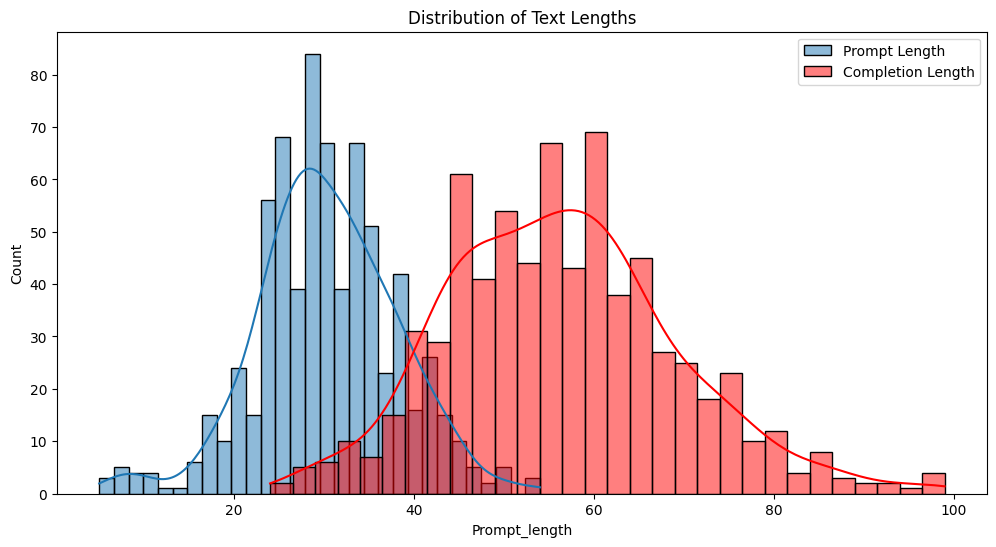

In [ ]:
# Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sentence_transformers import SentenceTransformer

# Text and Token Length distribution
df['Prompt_length'] = df['Prompt'].apply(lambda x: len(x.split()))
df['Completion_length'] = df['Completion'].apply(lambda x: len(x.split()))

# Plot distribution
plt.figure(figsize=(12, 6))
sns.histplot(df['Prompt_length'], bins=30, kde=True, label="Prompt Length")
sns.histplot(df['Completion_length'], bins=30, kde=True, label="Completion Length", color='red')
plt.legend()
plt.title("Distribution of Text Lengths")
plt.show()


In [ ]:
# Named Entity Recognition
nlp = spacy.load("en_core_sci_sm")

def extract_entities(text):
    doc = nlp(text)
    return [ent.text for ent in doc.ents]

df['Prompt_Entities'] = df['Prompt'].apply(extract_entities)
df['Completion_Entities'] = df['Completion'].apply(extract_entities)

# Check some examples
df[['Prompt', 'Prompt_Entities', 'Completion', 'Completion_Entities']].head()


,Prompt,Prompt_Entities,Completion,Completion_Entities
741,60-year-old male with history of gallstones pr...,"[male, history of gallstones, right upper quad...",this patient's symptoms raise concern for gall...,"[patient's, symptoms, raise concern, gallbladd..."
865,72-year-old female with severe copd experienci...,"[female, severe, copd, increased, frequency, e...",for patient with severe copd experiencing freq...,"[patient, severe, copd, exacerbations, triple ..."
339,48-year-old female patient suffers from chroni...,"[female, patient suffers, chronic inflammatory...","topical turmeric, in form of creams or ointmen...","[topical turmeric, creams, ointments, oral sup..."
192,"7-year-old boy presents with sore throat, diff...","[boy, sore throat, difficulty swallowing, feve...","symptoms findings suggest scarlet fever, which...","[symptoms, findings, scarlet, fever, condition..."
203,34-year-old female stung by bee experiences im...,"[female, stung, bee, experiences, swelling, it...",this patient likely experiencing an anaphylact...,"[patient, anaphylactic reaction, medical emerg..."


In [ ]:
# Generate Sentence Embeddings for Prompt(Symptoms)
# Load Sentence Transformer model
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Generate embeddings for Prompt
prompt_embeddings = model.encode(df['Prompt'].tolist(), convert_to_tensor=True)

# Store embeddings
df['Prompt_Embeddings'] = list(prompt_embeddings.cpu().numpy())


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

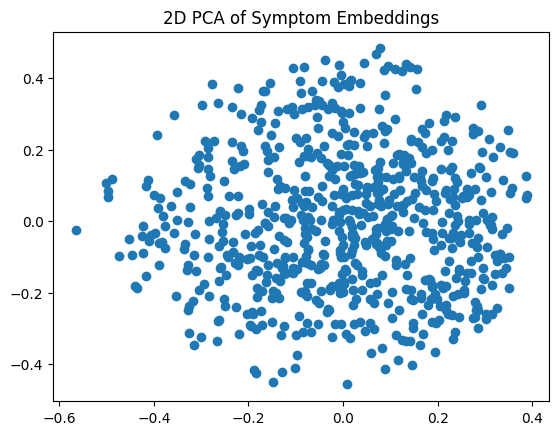

In [ ]:
# Explore Relationships in Data (Embeddings & Similarity)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(prompt_embeddings.cpu().numpy())

# Plot Symptom Embeddings
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
plt.title("2D PCA of Symptom Embeddings")
plt.show()

# Feature Engineering



In [ ]:
!pip install umap-learn
!pip install hdbscan

In [ ]:
# Generate embeddings for Completion (Diagnoses/Outcomes)
completion_embeddings = model.encode(df['Completion'].tolist(), convert_to_tensor=True)

# Store embeddings
df['Completion_Embeddings'] = list(completion_embeddings.cpu().numpy())

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Silhouette Score for HDBSCAN: 0.3925520181655884


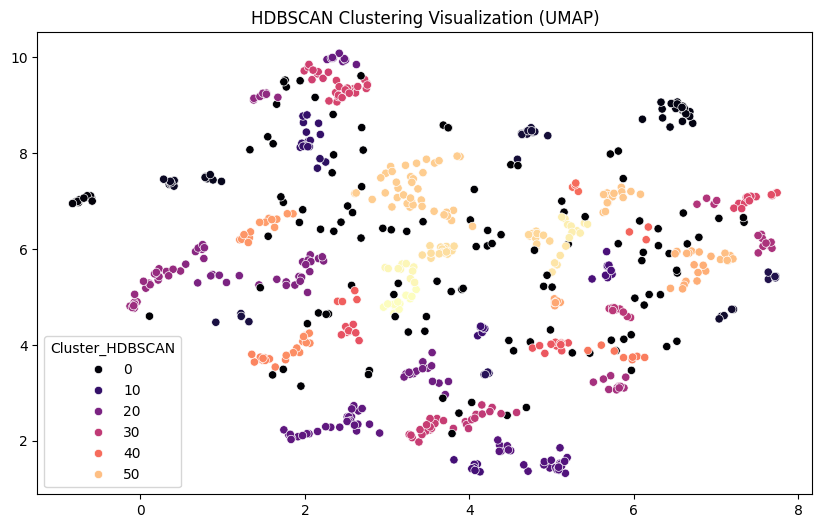

In [ ]:
# Group similar completion classes
import umap
import hdbscan
from sklearn.metrics import silhouette_score

# Reduce dimensionality with UMAP
umap_embeddings = umap.UMAP(n_components=2, random_state=42).fit_transform(completion_embeddings.cpu().numpy())

# Apply HDBSCAN
hdbscan_cluster = hdbscan.HDBSCAN(min_cluster_size=3, min_samples=3)
df['Cluster_HDBSCAN'] = hdbscan_cluster.fit_predict(umap_embeddings)

# Compute Silhouette Score
silhouette_hdbscan = silhouette_score(umap_embeddings, df['Cluster_HDBSCAN'])
print(f"Silhouette Score for HDBSCAN: {silhouette_hdbscan}")

# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=umap_embeddings[:, 0], y=umap_embeddings[:, 1], hue=df['Cluster_HDBSCAN'], palette="magma")
plt.title("HDBSCAN Clustering Visualization (UMAP)")
plt.show()


In [ ]:
# Display sample cases from each HDBSCAN cluster
for cluster in df['Cluster_HDBSCAN'].unique():
    print(f"\nCluster {cluster}:")
    # Get the cluster data
    cluster_data = df[df['Cluster_HDBSCAN'] == cluster]['Completion']
    # Sample a maximum of 5 elements or the cluster size, whichever is smaller
    sample_size = min(5, len(cluster_data))
    print(cluster_data.sample(sample_size, random_state=42).tolist())



Cluster 15:
["this patient's symptoms raise concern for gallbladder cancer, rare but serious condition that can be associated with history of gallstones. cancer can cause local symptoms (pain, jaundice) systemic symptoms (weight loss, new-onset diabetes). next step to obtain an abdominal ultrasound. if ultrasound concerning for malignancy, further imaging such as ct scan or mri may be necessary. depending on findings, patient may require surgical intervention possibly other treatments like chemotherapy or radiation therapy.", "this patient's presentation suggests complication of gallstones such as acute cholecystitis (inflammation of gallbladder) or choledocholithiasis (gallstone in common bile duct) with potential cholangitis (infection in bile duct). blood tests should be obtained, including complete blood count, liver function tests, pancreatic enzymes. imaging with an abdominal ultrasound crucial next step, if choledocholithiasis with cholangitis suspected, an ercp (endoscopic ret

In [ ]:
print("Number of noise points (Cluster -1):", (df['Cluster_HDBSCAN'] == -1).sum())


Number of noise points (Cluster -1): 114


In [ ]:
from datasets import Dataset  # Import the Dataset class

# Option 1: More comprehensive filtering
print("Before filtering:", len(df))  # Changed 'dataset' to 'df'
dataset = Dataset.from_pandas(df)  # Create a Hugging Face Dataset from 'df'
dataset = dataset.filter(lambda example: example['Cluster_HDBSCAN'] != -1)  # Filter noise points
print("After filtering:", len(dataset))

Before filtering: 706


Filter:   0%|          | 0/706 [00:00<?, ? examples/s]

After filtering: 592


# Model Training and Evaluation


In [ ]:
!pip install transformers datasets torch accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load dataset into Hugging Face Dataset format
dataset = Dataset.from_pandas(df[['Prompt', 'Cluster_HDBSCAN']])

# Load BERT tokenizer (Use 'dmis-lab/biobert-base-cased-v1.1' for BioBERT)
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Tokenize dataset
def tokenize_function(examples):
    # Convert 'Cluster_HDBSCAN' to a list of strings
    # This is crucial for batched processing
    text_pairs = [str(cluster) for cluster in examples["Cluster_HDBSCAN"]]

    # Tokenize using batch_text with text and text_pair lists
    return tokenizer(
        examples["Prompt"],
        padding="max_length",
        truncation=True,
        text_pair=text_pairs, # Pass the list of text_pairs
        return_tensors="pt"
    )

#include labels during tokenization and formatting
dataset = dataset.map(tokenize_function, batched=True)

#rename Cluster_HDBSCAN to labels
dataset = dataset.rename_column("Cluster_HDBSCAN", "labels")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/706 [00:00<?, ? examples/s]

In [ ]:
from sklearn.model_selection import train_test_split

# Convert to pandas DataFrame
df_split = dataset.to_pandas()

# Filter out noise points (labels == -1)
df_filtered = df_split[df_split['labels'] != -1]
print("After filtering noise:", len(df_filtered))

# Split using the filtered DataFrame
train_df, test_df = train_test_split(
    df_filtered,
    test_size=0.2,
    stratify=df_filtered['labels'],
    random_state=42
)

# Convert back to Hugging Face Dataset
from datasets import Dataset
train_dataset = Dataset.from_pandas(train_df, preserve_index=False)
test_dataset = Dataset.from_pandas(test_df, preserve_index=False)

# Update num_labels based on training data
num_labels = train_df['labels'].nunique()

# Load pretrained BERT model
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=num_labels
)

# Enable gradient checkpointing to reduce memory consumption
model.gradient_checkpointing_enable()


After filtering noise: 592


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
!nvidia-smi  # Check if GPU is being used

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
from transformers import TrainingArguments, Trainer

# Define training arguments
training_args = TrainingArguments(
    output_dir="./bert_symptom_checker",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=2,  # Reduced from 8
    per_device_eval_batch_size=2,   # Reduced from 8
    num_train_epochs=5,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    report_to="none"
)

# Define trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-22-b55b63660140>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
 import gc
import torch

gc.collect()
torch.cuda.empty_cache()

# Train model
trainer.train()

Epoch,Training Loss,Validation Loss
1,3.761000,3.236454
2,2.518100,2.179384
3,1.827300,1.626052
4,1.571400,1.365340


Epoch,Training Loss,Validation Loss
1,3.761000,3.236454
2,2.518100,2.179384
3,1.827300,1.626052
4,1.571400,1.365340
5,1.525000,1.279777


TrainOutput(global_step=1185, training_loss=2.3996273314399557, metrics={'train_runtime': 25350.8135, 'train_samples_per_second': 0.093, 'train_steps_per_second': 0.047, 'total_flos': 622576104944640.0, 'train_loss': 2.3996273314399557, 'epoch': 5.0})

In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.9 MB/s eta 0:00:00


In [ ]:
from evaluate import load  # Correct import from the evaluate library

# Load the accuracy metric
accuracy_metric = load("accuracy")

# Get predictions
results = trainer.predict(test_dataset)
predictions = results.predictions.argmax(-1)
labels = results.label_ids

# Compute accuracy
accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
print("Accuracy:", accuracy)

# Load and compute F1-score
f1_metric = load("f1")
f1_score = f1_metric.compute(predictions=predictions, references=labels, average="weighted")
print("F1-score:", f1_score)

Accuracy: {'accuracy': 0.957983193277311}


F1-score: {'f1': 0.942296918767507}


In [ ]:
# Load precision and recall metrics
precision_metric = load("precision")
recall_metric = load("recall")

# Compute precision
precision = precision_metric.compute(predictions=predictions, references=labels, average="weighted")

# Compute recall
recall = recall_metric.compute(predictions=predictions, references=labels, average="weighted")

print("Precision:", precision)
print("Recall:", recall)

In [ ]:
# Define the directory where the model and tokenizer are saved
model_dir = "/content/bert_symptom_checker"

# Save model and tokenizer
model.save_pretrained(model_dir, safe_serialization=False)
tokenizer.save_pretrained(model_dir)

('/content/bert_symptom_checker/tokenizer_config.json',
 '/content/bert_symptom_checker/special_tokens_map.json',
 '/content/bert_symptom_checker/vocab.txt',
 '/content/bert_symptom_checker/added_tokens.json',
 '/content/bert_symptom_checker/tokenizer.json')

In [ ]:
# Try saving with explicit verbose output
print("Saving model...")
model.save_pretrained(model_dir, safe_serialization=False)
print("Save complete.")
print("Files in directory:", os.listdir(model_dir))

# Check if config.json exists (should always be present)
if "config.json" in os.listdir(model_dir):
    print("config.json exists, checking contents...")
    with open(os.path.join(model_dir, "config.json"), "r") as f:
        print(f.read()[:100])  # Print first 100 chars
else:
    print("config.json missing!")

Saving model...
Save complete.
Files in directory: ['checkpoint-948', 'checkpoint-1185', 'model.safetensors', 'config.json', 'checkpoint-474', 'checkpoint-711', 'vocab.txt', 'tokenizer_config.json', 'special_tokens_map.json', 'checkpoint-237', 'pytorch_model.bin', 'tokenizer.json']
config.json exists, checking contents...
{
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForSequenceClassification"
 


In [ ]:
import os

# Define the required files
required_files = [
    "pytorch_model.bin",
    "model.safetensors",
    "tf_model.h5",
    "model.ckpt",
    "flax_model.msgpack",
    "config.json",
    "tokenizer_config.json",
    "vocab.txt",  # or other tokenizer files
    "special_tokens_map.json",
    "tokenizer.json"
]

# Function to check for required files in a directory
def check_files_in_directory(directory, required_files):
    files = os.listdir(directory)
    missing_files = [file for file in required_files if file not in files]
    return missing_files

# Check the main directory
missing_files = check_files_in_directory(model_dir, required_files)
if not missing_files:
    print(f"All required files are present in {model_dir}.")
else:
    print(f"Missing files in {model_dir}: {missing_files}")

# Check subdirectories
for subdir in os.listdir(model_dir):
    subdir_path = os.path.join(model_dir, subdir)
    if os.path.isdir(subdir_path):
        missing_files = check_files_in_directory(subdir_path, required_files)
        if not missing_files:
            print(f"All required files are present in {subdir_path}.")
        else:
            print(f"Missing files in {subdir_path}: {missing_files}")

Missing files in /content/bert_symptom_checker: ['tf_model.h5', 'model.ckpt', 'flax_model.msgpack']
Missing files in /content/bert_symptom_checker/checkpoint-948: ['pytorch_model.bin', 'tf_model.h5', 'model.ckpt', 'flax_model.msgpack']
Missing files in /content/bert_symptom_checker/checkpoint-1185: ['pytorch_model.bin', 'tf_model.h5', 'model.ckpt', 'flax_model.msgpack']
Missing files in /content/bert_symptom_checker/checkpoint-474: ['pytorch_model.bin', 'tf_model.h5', 'model.ckpt', 'flax_model.msgpack']
Missing files in /content/bert_symptom_checker/checkpoint-711: ['pytorch_model.bin', 'tf_model.h5', 'model.ckpt', 'flax_model.msgpack']
Missing files in /content/bert_symptom_checker/checkpoint-237: ['pytorch_model.bin', 'tf_model.h5', 'model.ckpt', 'flax_model.msgpack']


In [ ]:
!pip install huggingface_hub

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from huggingface_hub import HfApi

api = HfApi()

# Create the repository (or use existing one)
try:
    api.create_repo(repo_id="Lech-Iyoko/bert-symptom-checker", repo_type="model")
    print("Repository created successfully")
except Exception as e:
    print(f"Repository already exists or error occurred: {e}")

# Upload only the necessary files (ignore checkpoints)
essential_files = [
    "/content/bert_symptom_checker/pytorch_model.bin",
    "/content/bert_symptom_checker/model.safetensors",
    "/content/bert_symptom_checker/config.json",
    "/content/bert_symptom_checker/tokenizer_config.json",
    "/content/bert_symptom_checker/vocab.txt",
    "/content/bert_symptom_checker/special_tokens_map.json",
    "/content/bert_symptom_checker/tokenizer.json"
]

# Check if files exist before uploading
import os
files_to_upload = [f for f in essential_files if os.path.exists(f)]
print(f"Uploading {len(files_to_upload)} files...")

# Upload files individually
for file_path in files_to_upload:
    file_name = os.path.basename(file_path)
    try:
        api.upload_file(
            path_or_fileobj=file_path,
            path_in_repo=file_name,
            repo_id="Lech-Iyoko/bert-symptom-checker",
            repo_type="model"
        )
        print(f"Uploaded {file_name}")
    except Exception as e:
        print(f"Error uploading {file_name}: {e}")

print("Upload complete!")

Repository already exists or error occurred: 409 Client Error: Conflict for url: https://huggingface.co/api/repos/create (Request ID: Root=1-67d38302-49cf6ba118f181d44b4fcb04;73148972-7809-4757-960a-42de52c6fba1)

You already created this model repo
Uploading 7 files...


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Uploaded pytorch_model.bin


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Uploaded model.safetensors


No files have been modified since last commit. Skipping to prevent empty commit.


Uploaded config.json


No files have been modified since last commit. Skipping to prevent empty commit.


Uploaded tokenizer_config.json
Uploaded vocab.txt


No files have been modified since last commit. Skipping to prevent empty commit.


Uploaded special_tokens_map.json


No files have been modified since last commit. Skipping to prevent empty commit.


Uploaded tokenizer.json
Upload complete!
